## Подготовка данных

In [ ]:
# Импортируем библиотеки
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
batch_size=32 # Размер батча

**Названия классов в наборах данных**

In [ ]:
class_names = ['No', 'edible', 'hallucinogenic', 'inedible', 'poisonous']

**Перевод фото в тензорные изображения**

In [ ]:
path_to_folder = 'PATH' # Путь к папке
batch_size = 20
train_path = os.path.join(path_to_folder, 'Train')
valid_path = os.path.join(path_to_folder, 'Valid')
test_path = os.path.join(path_to_folder, 'Test')
target_size = (224, 224) # Размер входного изображения

# Формирование выборок для модели
train_batches = ImageDataGenerator(
    preprocessing_function=keras.applications.densenet.preprocess_input
).flow_from_directory(
    directory=train_path, target_size=target_size, classes=class_names, batch_size=batch_size)

valid_batches = ImageDataGenerator(
    preprocessing_function=keras.applications.densenet.preprocess_input
).flow_from_directory(
    directory=valid_path, target_size=target_size, classes=class_names, batch_size=batch_size)

test_batches = ImageDataGenerator(
    preprocessing_function=keras.applications.densenet.preprocess_input
).flow_from_directory(
    directory=test_path, target_size=target_size, classes=class_names, batch_size=batch_size,
    shuffle=False)

Found 1579 images belonging to 5 classes.
Found 394 images belonging to 5 classes.
Found 204 images belonging to 5 classes.


Данный распределены на тренировочную/валидационную/тестовую выборку в процентном соотношение 72/18/10. Каждая из выборок содержит по 5 классов

## Обучение модели

**Загрузка модели**

In [ ]:
dense_net = keras.applications.DenseNet201()

82524592/82524592 [==============================] - 5s 0us/step


In [ ]:
dense_net.summary() # Структура свёрточной нейросети

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

**Добавление последнего слоя классификации классов**

In [ ]:
x = dense_net.layers[-1].output
output = Dense(len(class_names), activation='softmax')(x) 
model = Model(inputs=dense_net.input, outputs=output)

**Отключение у первых 24 слоёв способность обучения**

In [ ]:
for layer in model.layers[:-24]:
    layer.trainable = False

**Настройка ранней остановки обучения и модели**

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10, 
    min_delta=0.001,
    restore_best_weights=True, 
)

model.compile(
    optimizer='Adam', 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

**Отключение предупреждений у модели**

In [ ]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


**Обучение модели**

In [ ]:
%%time
# Обучаем модель
history = model.fit(
    x=train_batches,
    validation_data=valid_batches,
    epochs=150,
    callbacks=[early_stopping]
)

Epoch 1/150
79/79 [==============================] - 77s 823ms/step - loss: 1.5394 - accuracy: 0.4490 - val_loss: 1.4850 - val_accuracy: 0.4569
Epoch 2/150
79/79 [==============================] - 62s 783ms/step - loss: 1.4428 - accuracy: 0.4528 - val_loss: 1.4076 - val_accuracy: 0.4518
Epoch 3/150
79/79 [==============================] - 62s 784ms/step - loss: 1.3539 - accuracy: 0.5022 - val_loss: 1.3243 - val_accuracy: 0.5406
Epoch 4/150
79/79 [==============================] - 62s 785ms/step - loss: 1.2745 - accuracy: 0.5389 - val_loss: 1.2793 - val_accuracy: 0.5228
Epoch 5/150
79/79 [==============================] - 62s 787ms/step - loss: 1.2081 - accuracy: 0.5459 - val_loss: 1.2319 - val_accuracy: 0.5305
Epoch 6/150
79/79 [==============================] - 62s 784ms/step - loss: 1.1486 - accuracy: 0.5535 - val_loss: 1.2180 - val_accuracy: 0.5228
Epoch 7/150
79/79 [==============================] - 65s 820ms/step - loss: 1.1083 - accuracy: 0.5548 - val_loss: 1.1654 - val_accuracy:

**Просмотр потерь и точности на тренировочных и валидационных данных**

<Axes: title={'center': 'Accuracy'}>

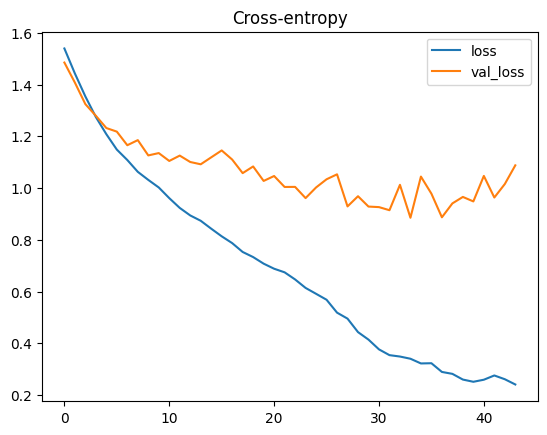

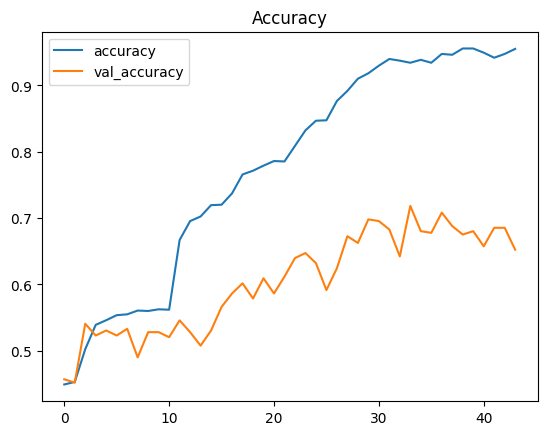

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

Вывод по графикам:

    После 32 эпохи модель начала переобучаться

**Точность модели на тестовой выборке**

In [ ]:
scores = model.evaluate(test_batches)
print(f'Accuracy: {round((scores[1]*100), 2)}%')

11/11 [==============================] - 4s 387ms/step - loss: 0.9027 - accuracy: 0.7108
Accuracy: 71.08%


Точность модели составляет 71.08%, что является не плохим результатом

**Сохранение модели**

In [ ]:
model.save('my_model.h5')